In [1]:
import numpy as np 
import time

import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import RobustScaler
import os
os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Repos\InceptionTime-Pytorch-master')
import pandas as pd

from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import json

from google.cloud import bigquery
from google.oauth2 import service_account
import datetime
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
from inception import Inception, InceptionBlock

In [3]:
class Flatten(nn.Module):
    def __init__(self, out_features):
        super(Flatten, self).__init__()
        self.output_dim = out_features

    def forward(self, x):
        return x.view(-1, self.output_dim)
    
class Reshape(nn.Module):
    def __init__(self, out_shape):
        super(Reshape, self).__init__()
        self.out_shape = out_shape

    def forward(self, x):
        return x.view(-1, *self.out_shape)

In [4]:
def label_data(training_data,labels):
    training_data['label']='no_event'
    for appliance,label,time in zip(labels.equipment_type,labels.event_type,labels.event_time):
        if label=='ON':
            start_time = time - datetime.timedelta(milliseconds=250)
            end_time = time + datetime.timedelta(milliseconds=750)
        else:
            start_time = time - datetime.timedelta(milliseconds=750)
            end_time = time + datetime.timedelta(milliseconds=250)
#         else:
#             start_time = time - datetime.timedelta(milliseconds=200)
#             end_time = time + datetime.timedelta(milliseconds=200)

        training_data.loc[(training_data.logged_on_utc>=start_time) & (training_data.logged_on_utc<=end_time),'label']= appliance+'_'+label

    return training_data

def import_labels(property_id):
    labels=pd.read_excel('labelled_data_07072021.xlsx')
    labels=labels[labels['lead_property_id']==property_id]
    labels['event_time']=[datetime.datetime.fromtimestamp(timestamp/1000)-datetime.timedelta(hours=5.5) for timestamp in labels['event_time']]
    return labels

def import_appliance_training_data(property_id,appliance):
    os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Vizualisations\Config')
    credentials = service_account.Credentials.from_service_account_file('bigqueryauth.json')
    project_id = 'solar-222307'
    client = bigquery.Client(credentials= credentials,project=project_id)
    
    os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Raycon\Raycon Data')
#     labels=import_labels(property_id)
#     training_data=pd.read_pickle('raycon_appliance_training_data.pkl')
#     training_data['logged_on_utc']=pd.to_datetime(training_data['logged_on_utc'])
#     last_timestamp=training_data.sort_values('logged_on_utc')['logged_on_utc'].iloc[-1]
    last_timestamp='2000-11-11'
    labels=import_labels(property_id)
    
    
    query=''
    for time in labels[(labels.event_time>last_timestamp) & (labels.equipment_type==appliance)].event_time:
        start_time = time - datetime.timedelta(seconds=10)
        end_time = time + datetime.timedelta(seconds=10)
        query= query + 'logged_on_utc >= "'+ str(start_time) + '" and logged_on_utc <= "' + str(end_time) + '" or '
    
    if query=='':
        return training_data
    else:
        query = 'select * from dev_loggers.raycon where '+ query[:-4] + ' order by logged_on_utc'
        query_job=client.query(query)       
        results = query_job.result().to_dataframe()
        training_data = results.dropna(subset=['logged_on_utc'])
#         results['logged_on_utc']=pd.to_datetime(results['logged_on_utc'])
        training_data['logged_on_utc']=pd.to_datetime(training_data['logged_on_utc'])
#         training_data=training_data.append(results)
        training_data=training_data.drop_duplicates(subset=['logged_on_utc'])
#         training_data=training_data.reset_index()
        training_data=label_data(training_data,labels)
#         training_data.to_pickle('raycon_appliance_training_data.pkl')
        return training_data


In [5]:
training_data=import_appliance_training_data(20,'Refrigerator')
training_data=training_data[training_data['label'].isin(['Refrigerator_OFF','Refrigerator_ON','no_event'])]
training_data['mains_power']=training_data['active_power_P1']+training_data['active_power_P2']+training_data['active_power_P3']
training_data=training_data.sort_values('logged_on_utc')

In [6]:
def get_features(x):
    
    x['prev_mean']=x['mains_power'].rolling(5).mean()
    x['time_since_last_event']=0
    x['time_since_event_start']=0
    x['normalized_mains_power']=0

    prev_mean=0
    prev_activity_time = pd.to_datetime('2021-02-27')
    current_activity_time = pd.to_datetime('2021-02-27')   
    activity_ongoing = False

    for i in range(len(x)):

        label = x['label'].iloc[i]

        if (label != 'no_event') and (activity_ongoing == False):
            current_activity_time = x['logged_on_utc'].iloc[i]
            prev_mean = x['prev_mean'].iloc[i]
            activity_ongoing=True

        elif (label == 'no_event') and (activity_ongoing == True):
            prev_activity_time = x['logged_on_utc'].iloc[i]
            activity_ongoing = False
            activity_ongoing = False

        elif (label!= 'no_event') and (activity_ongoing == True):
            x['time_since_last_event'].iloc[i] = (x['logged_on_utc'].iloc[i]-prev_activity_time).microseconds/1000000 + (x['logged_on_utc'].iloc[i]-prev_activity_time).seconds
            x['time_since_event_start'].iloc[i] = (x['logged_on_utc'].iloc[i]-current_activity_time).microseconds/1000000 +(x['logged_on_utc'].iloc[i]-current_activity_time).seconds  
            x['normalized_mains_power'].iloc[i] = x['mains_power'].iloc[i]-prev_mean

        elif (label== 'no_event') and (activity_ongoing == False):
            x['time_since_last_event'].iloc[i] = (x['logged_on_utc'].iloc[i]-prev_activity_time).microseconds/1000000 + (x['logged_on_utc'].iloc[i]-prev_activity_time).seconds
            x['time_since_event_start'].iloc[i] = 0  
            x['normalized_mains_power'].iloc[i] = x['mains_power'].iloc[i]-prev_mean
    return x
        
x = get_features(training_data)


In [7]:
x_values=x[['mains_power','prev_mean','time_since_last_event','time_since_event_start', 'normalized_mains_power']].fillna(0)
LOOK_BACK=15
def create_dataset (X, look_back = 7):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
#         v = X['mains_power'][i:i+look_back].values
        v = X[i:i+look_back].values
        Xs.append(v)
        ys.append(dummy_y[i+look_back])
 
    return np.array(Xs).reshape(len(Xs), look_back, len(X.columns)), np.array(ys)

# encode and transform labels 
encoder = LabelEncoder()
encoder.fit(training_data['label'])
encoded_Y = encoder.transform(training_data['label'])

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

X_train, y_train = create_dataset(x_values,LOOK_BACK)
X_train_back, y_train_back = X_train, y_train
# X_train, y_train = create_dataset(training_data.loc[training_data.reset_index().index.isin(pd.Index(lis))])

In [8]:
print(len(x_values))
print(len(training_data))

33916
33916


In [9]:
X_train.shape

(33901, 15, 5)

In [10]:
pd.DataFrame(y_train).sum()
# data.reset_index()[data.reset_index()['label']!=''].pivot_table(index='label', aggfunc='count')

0      795.0
1      997.0
2    32109.0
dtype: float32

In [11]:
len(X_train[0])

15

In [12]:
# X = np.vstack((np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt1.npy"),
#                np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt2.npy")))
# y = np.load("data/sequenced_data_for_VAE_length-160_stride-10_targets.npy")
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

In [13]:

InceptionTime = nn.Sequential(
                    Reshape(out_shape=(5,LOOK_BACK)),
                    InceptionBlock(
                        in_channels=5, 
                        n_filters=32, 
                        kernel_sizes=[5,13,23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5,13,23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveMaxPool1d(output_size=1),
#     nn.AdaptiveMaxPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=3)
        )

In [14]:
tensor_x = torch.Tensor(X_train) # transform to torch tensor
tensor_y = torch.Tensor(y_train)

# scaler = RobustScaler()
# X_train = scaler.fit_transform(tensor_x)
# X_test = scaler.transform(tensor_y)

dataset = TensorDataset(tensor_x,tensor_y) # create your datset
trainloader = DataLoader(dataset,batch_size=512) # create your dataloader


In [15]:
net=InceptionTime
import torch.optim as optim
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# for epoch in range(epochs):
#     for inputs, labels in trainloader:
#         inputs, labels = inputs.to(device), labels.to(device)

net.to(device)

# start_lr = 1e-7
# end_lr = .1
epochs=50

optimizer = optim.Adam(net.parameters(), lr=0.03)
# lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (epochs * len(trainloader.dataset)))
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

criterion = nn.BCEWithLogitsLoss()
weight = torch.tensor([10.0, 10.0, 1.0])
# itera=0
# lr_find_lr=[]
# lr_find_loss=[]
# smoothing=-1e-7
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        weight = weight.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss = loss * weight
        loss = loss.mean()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss))
        running_loss = 0.0
        
#         # Update LR
#         scheduler.step()
#         lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
#         lr_find_lr.append(lr_step)
        
#             # smooth the loss
#         if itera==0:
#             lr_find_loss.append(loss)
#         else:
#             loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
#             lr_find_loss.append(loss)

#         itera += 1

[1,     1] loss: 9.987
[1,     2] loss: 3.015
[1,     3] loss: 0.734
[1,     4] loss: 2.328
[1,     5] loss: 3.370
[1,     6] loss: 2.403
[1,     7] loss: 3.142
[1,     8] loss: 1.935
[1,     9] loss: 2.026
[1,    10] loss: 4.443
[1,    11] loss: 1.064
[1,    12] loss: 1.765
[1,    13] loss: 2.072
[1,    14] loss: 0.703
[1,    15] loss: 1.135
[1,    16] loss: 1.561
[1,    17] loss: 0.455
[1,    18] loss: 1.324
[1,    19] loss: 1.444
[1,    20] loss: 0.485
[1,    21] loss: 1.357
[1,    22] loss: 0.792
[1,    23] loss: 1.178
[1,    24] loss: 0.538
[1,    25] loss: 0.829
[1,    26] loss: 1.119
[1,    27] loss: 0.389
[1,    28] loss: 0.318
[1,    29] loss: 0.978
[1,    30] loss: 0.353
[1,    31] loss: 1.050
[1,    32] loss: 1.193
[1,    33] loss: 1.515
[1,    34] loss: 0.729
[1,    35] loss: 0.708
[1,    36] loss: 1.669
[1,    37] loss: 0.362
[1,    38] loss: 0.926
[1,    39] loss: 1.104
[1,    40] loss: 0.394
[1,    41] loss: 0.882
[1,    42] loss: 0.685
[1,    43] loss: 0.314
[1,    44] 

[6,    26] loss: 0.173
[6,    27] loss: 0.106
[6,    28] loss: 0.093
[6,    29] loss: 0.221
[6,    30] loss: 0.082
[6,    31] loss: 0.164
[6,    32] loss: 0.091
[6,    33] loss: 0.860
[6,    34] loss: 0.126
[6,    35] loss: 0.073
[6,    36] loss: 0.206
[6,    37] loss: 0.099
[6,    38] loss: 0.228
[6,    39] loss: 0.375
[6,    40] loss: 0.222
[6,    41] loss: 0.229
[6,    42] loss: 0.093
[6,    43] loss: 0.082
[6,    44] loss: 0.123
[6,    45] loss: 0.215
[6,    46] loss: 0.137
[6,    47] loss: 0.092
[6,    48] loss: 0.160
[6,    49] loss: 0.091
[6,    50] loss: 0.106
[6,    51] loss: 0.161
[6,    52] loss: 0.099
[6,    53] loss: 0.099
[6,    54] loss: 0.142
[6,    55] loss: 0.093
[6,    56] loss: 0.084
[6,    57] loss: 0.157
[6,    58] loss: 0.116
[6,    59] loss: 0.084
[6,    60] loss: 0.150
[6,    61] loss: 0.115
[6,    62] loss: 0.074
[6,    63] loss: 0.141
[6,    64] loss: 0.099
[6,    65] loss: 0.105
[6,    66] loss: 0.181
[6,    67] loss: 0.050
[7,     1] loss: 0.517
[7,     2] 

[11,    44] loss: 0.087
[11,    45] loss: 0.373
[11,    46] loss: 0.175
[11,    47] loss: 0.084
[11,    48] loss: 0.156
[11,    49] loss: 0.092
[11,    50] loss: 0.084
[11,    51] loss: 0.190
[11,    52] loss: 0.095
[11,    53] loss: 0.083
[11,    54] loss: 0.174
[11,    55] loss: 0.112
[11,    56] loss: 0.085
[11,    57] loss: 0.171
[11,    58] loss: 0.144
[11,    59] loss: 0.081
[11,    60] loss: 0.150
[11,    61] loss: 0.096
[11,    62] loss: 0.079
[11,    63] loss: 0.144
[11,    64] loss: 0.092
[11,    65] loss: 0.109
[11,    66] loss: 0.190
[11,    67] loss: 0.009
[12,     1] loss: 0.455
[12,     2] loss: 0.161
[12,     3] loss: 0.368
[12,     4] loss: 0.087
[12,     5] loss: 0.180
[12,     6] loss: 0.152
[12,     7] loss: 0.277
[12,     8] loss: 0.504
[12,     9] loss: 0.323
[12,    10] loss: 0.866
[12,    11] loss: 0.188
[12,    12] loss: 0.103
[12,    13] loss: 0.272
[12,    14] loss: 0.103
[12,    15] loss: 0.091
[12,    16] loss: 0.152
[12,    17] loss: 0.156
[12,    18] loss

[16,    54] loss: 0.179
[16,    55] loss: 0.076
[16,    56] loss: 0.079
[16,    57] loss: 0.139
[16,    58] loss: 0.117
[16,    59] loss: 0.075
[16,    60] loss: 0.141
[16,    61] loss: 0.085
[16,    62] loss: 0.074
[16,    63] loss: 0.145
[16,    64] loss: 0.084
[16,    65] loss: 0.098
[16,    66] loss: 0.143
[16,    67] loss: 0.084
[17,     1] loss: 0.296
[17,     2] loss: 0.153
[17,     3] loss: 0.075
[17,     4] loss: 0.081
[17,     5] loss: 0.166
[17,     6] loss: 0.127
[17,     7] loss: 0.164
[17,     8] loss: 0.308
[17,     9] loss: 0.411
[17,    10] loss: 0.154
[17,    11] loss: 0.090
[17,    12] loss: 0.092
[17,    13] loss: 0.142
[17,    14] loss: 0.092
[17,    15] loss: 0.088
[17,    16] loss: 0.149
[17,    17] loss: 0.084
[17,    18] loss: 0.078
[17,    19] loss: 0.136
[17,    20] loss: 0.083
[17,    21] loss: 0.165
[17,    22] loss: 0.076
[17,    23] loss: 0.154
[17,    24] loss: 0.088
[17,    25] loss: 0.085
[17,    26] loss: 0.164
[17,    27] loss: 0.088
[17,    28] loss

[21,    65] loss: 0.084
[21,    66] loss: 0.120
[21,    67] loss: 0.000
[22,     1] loss: 0.146
[22,     2] loss: 0.145
[22,     3] loss: 0.069
[22,     4] loss: 0.079
[22,     5] loss: 0.142
[22,     6] loss: 0.129
[22,     7] loss: 0.145
[22,     8] loss: 0.122
[22,     9] loss: 0.102
[22,    10] loss: 0.137
[22,    11] loss: 0.080
[22,    12] loss: 0.103
[22,    13] loss: 0.120
[22,    14] loss: 0.079
[22,    15] loss: 0.076
[22,    16] loss: 0.117
[22,    17] loss: 0.077
[22,    18] loss: 0.072
[22,    19] loss: 0.127
[22,    20] loss: 0.075
[22,    21] loss: 0.152
[22,    22] loss: 0.076
[22,    23] loss: 0.132
[22,    24] loss: 0.091
[22,    25] loss: 0.071
[22,    26] loss: 0.177
[22,    27] loss: 0.089
[22,    28] loss: 0.061
[22,    29] loss: 0.153
[22,    30] loss: 0.084
[22,    31] loss: 0.146
[22,    32] loss: 0.082
[22,    33] loss: 0.155
[22,    34] loss: 0.095
[22,    35] loss: 0.075
[22,    36] loss: 0.148
[22,    37] loss: 0.074
[22,    38] loss: 0.142
[22,    39] loss

[27,     8] loss: 0.099
[27,     9] loss: 0.084
[27,    10] loss: 0.127
[27,    11] loss: 0.072
[27,    12] loss: 0.077
[27,    13] loss: 0.118
[27,    14] loss: 0.071
[27,    15] loss: 0.069
[27,    16] loss: 0.116
[27,    17] loss: 0.075
[27,    18] loss: 0.078
[27,    19] loss: 0.123
[27,    20] loss: 0.069
[27,    21] loss: 0.141
[27,    22] loss: 0.064
[27,    23] loss: 0.132
[27,    24] loss: 0.094
[27,    25] loss: 0.070
[27,    26] loss: 0.166
[27,    27] loss: 0.094
[27,    28] loss: 0.062
[27,    29] loss: 0.161
[27,    30] loss: 0.085
[27,    31] loss: 0.136
[27,    32] loss: 0.075
[27,    33] loss: 0.133
[27,    34] loss: 0.084
[27,    35] loss: 0.091
[27,    36] loss: 0.144
[27,    37] loss: 0.074
[27,    38] loss: 0.148
[27,    39] loss: 0.128
[27,    40] loss: 0.101
[27,    41] loss: 0.154
[27,    42] loss: 0.084
[27,    43] loss: 0.078
[27,    44] loss: 0.089
[27,    45] loss: 0.117
[27,    46] loss: 0.075
[27,    47] loss: 0.068
[27,    48] loss: 0.140
[27,    49] loss

[32,    19] loss: 0.123
[32,    20] loss: 0.070
[32,    21] loss: 0.139
[32,    22] loss: 0.063
[32,    23] loss: 0.127
[32,    24] loss: 0.087
[32,    25] loss: 0.068
[32,    26] loss: 0.154
[32,    27] loss: 0.087
[32,    28] loss: 0.059
[32,    29] loss: 0.152
[32,    30] loss: 0.082
[32,    31] loss: 0.143
[32,    32] loss: 0.075
[32,    33] loss: 0.129
[32,    34] loss: 0.085
[32,    35] loss: 0.083
[32,    36] loss: 0.135
[32,    37] loss: 0.074
[32,    38] loss: 0.138
[32,    39] loss: 0.115
[32,    40] loss: 0.096
[32,    41] loss: 0.144
[32,    42] loss: 0.071
[32,    43] loss: 0.074
[32,    44] loss: 0.089
[32,    45] loss: 0.113
[32,    46] loss: 0.080
[32,    47] loss: 0.067
[32,    48] loss: 0.136
[32,    49] loss: 0.076
[32,    50] loss: 0.073
[32,    51] loss: 0.137
[32,    52] loss: 0.075
[32,    53] loss: 0.070
[32,    54] loss: 0.151
[32,    55] loss: 0.071
[32,    56] loss: 0.080
[32,    57] loss: 0.128
[32,    58] loss: 0.098
[32,    59] loss: 0.069
[32,    60] loss

[37,    27] loss: 0.097
[37,    28] loss: 0.060
[37,    29] loss: 0.161
[37,    30] loss: 0.082
[37,    31] loss: 0.143
[37,    32] loss: 0.076
[37,    33] loss: 0.142
[37,    34] loss: 0.075
[37,    35] loss: 0.084
[37,    36] loss: 0.139
[37,    37] loss: 0.075
[37,    38] loss: 0.138
[37,    39] loss: 0.118
[37,    40] loss: 0.101
[37,    41] loss: 0.142
[37,    42] loss: 0.072
[37,    43] loss: 0.076
[37,    44] loss: 0.086
[37,    45] loss: 0.113
[37,    46] loss: 0.079
[37,    47] loss: 0.070
[37,    48] loss: 0.141
[37,    49] loss: 0.077
[37,    50] loss: 0.072
[37,    51] loss: 0.139
[37,    52] loss: 0.077
[37,    53] loss: 0.069
[37,    54] loss: 0.150
[37,    55] loss: 0.074
[37,    56] loss: 0.078
[37,    57] loss: 0.133
[37,    58] loss: 0.093
[37,    59] loss: 0.069
[37,    60] loss: 0.132
[37,    61] loss: 0.079
[37,    62] loss: 0.070
[37,    63] loss: 0.133
[37,    64] loss: 0.074
[37,    65] loss: 0.071
[37,    66] loss: 0.102
[37,    67] loss: 0.000
[38,     1] loss

[42,    36] loss: 0.139
[42,    37] loss: 0.073
[42,    38] loss: 0.143
[42,    39] loss: 0.117
[42,    40] loss: 0.092
[42,    41] loss: 0.134
[42,    42] loss: 0.078
[42,    43] loss: 0.081
[42,    44] loss: 0.089
[42,    45] loss: 0.109
[42,    46] loss: 0.091
[42,    47] loss: 0.071
[42,    48] loss: 0.148
[42,    49] loss: 0.078
[42,    50] loss: 0.080
[42,    51] loss: 0.138
[42,    52] loss: 0.078
[42,    53] loss: 0.072
[42,    54] loss: 0.133
[42,    55] loss: 0.071
[42,    56] loss: 0.074
[42,    57] loss: 0.124
[42,    58] loss: 0.097
[42,    59] loss: 0.073
[42,    60] loss: 0.132
[42,    61] loss: 0.081
[42,    62] loss: 0.079
[42,    63] loss: 0.143
[42,    64] loss: 0.077
[42,    65] loss: 0.074
[42,    66] loss: 0.104
[42,    67] loss: 0.000
[43,     1] loss: 0.067
[43,     2] loss: 0.131
[43,     3] loss: 0.072
[43,     4] loss: 0.070
[43,     5] loss: 0.132
[43,     6] loss: 0.067
[43,     7] loss: 0.155
[43,     8] loss: 0.078
[43,     9] loss: 0.076
[43,    10] loss

[47,    44] loss: 0.074
[47,    45] loss: 0.148
[47,    46] loss: 0.171
[47,    47] loss: 0.064
[47,    48] loss: 0.143
[47,    49] loss: 0.082
[47,    50] loss: 0.081
[47,    51] loss: 0.134
[47,    52] loss: 0.077
[47,    53] loss: 0.073
[47,    54] loss: 0.157
[47,    55] loss: 0.080
[47,    56] loss: 0.069
[47,    57] loss: 0.145
[47,    58] loss: 0.119
[47,    59] loss: 0.070
[47,    60] loss: 0.144
[47,    61] loss: 0.085
[47,    62] loss: 0.066
[47,    63] loss: 0.134
[47,    64] loss: 0.086
[47,    65] loss: 0.080
[47,    66] loss: 0.146
[47,    67] loss: 0.008
[48,     1] loss: 0.512
[48,     2] loss: 0.146
[48,     3] loss: 0.071
[48,     4] loss: 0.087
[48,     5] loss: 0.158
[48,     6] loss: 0.125
[48,     7] loss: 0.159
[48,     8] loss: 0.357
[48,     9] loss: 0.294
[48,    10] loss: 0.146
[48,    11] loss: 0.077
[48,    12] loss: 0.082
[48,    13] loss: 0.156
[48,    14] loss: 0.079
[48,    15] loss: 0.098
[48,    16] loss: 0.140
[48,    17] loss: 0.077
[48,    18] loss

In [16]:
# torch.cuda.
torch.cuda.empty_cache()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')



GeForce GTX 1650
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [17]:
  # entirely clear all allocated memory
# model = model.to(device)
InceptionTime.eval()
# x_pred=[]
# for i in range(len(dataset)):

x_pred=[]
with torch.no_grad():
    x_pred.append(np.argmax(InceptionTime(torch.tensor(dataset.tensors[0].to(device)).float()).cpu().detach(), axis=1))
#     for i in range(len(dataset.tensors[0])):
#         x_pred.append(np.argmax(InceptionTime(torch.tensor(dataset.tensors[0][i].to(device)).float()).cpu().detach(), axis=1))
pd.Series(x_pred).unique()

array([tensor([2, 2, 2,  ..., 2, 2, 2])], dtype=object)

In [18]:
# y_pred=[int(x_pred[i][0]) for i in range(len(x_pred))]
y_pred=[int(x_pred[0][i]) for i in range(len(x_pred[0]))]
y_true=[]
for i in y_train:
    if i[0]==1:
        y_true.append(0)
    elif i[1]==1:
        y_true.append(1)
    else:
        y_true.append(2)
        
print(f1_score(y_true=y_true, y_pred=y_pred,average="macro"))
print(accuracy_score(y_true=y_true, y_pred=y_pred))
cf1 = confusion_matrix(y_true=y_true, y_pred=y_pred) # x_axis = predicted, y_axis = ground_truth
print(cf1)

0.9092408885557369
0.9857231350107667
[[  736     0    59]
 [   16   933    48]
 [  199   162 31748]]


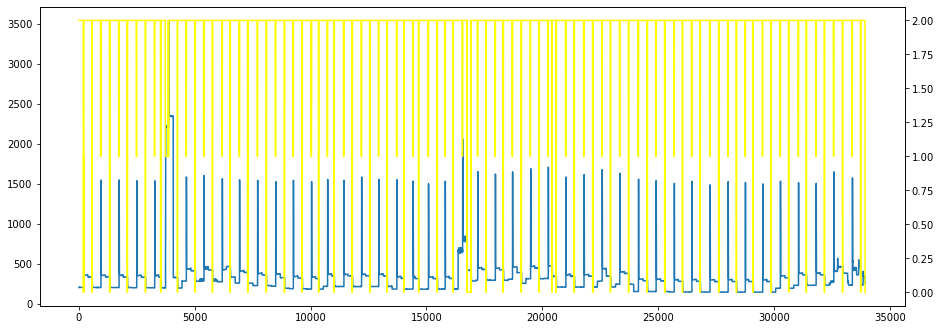

In [19]:
training_data['pred']=0
training_data['int_label']=0
training_data['pred'][:-15]=y_pred
training_data['int_label'][:-15]=y_true
start=0
end=40000
fig,ax=plt.subplots()
ax2=ax.twinx()
fig.set_size_inches(15.5, 5.5)
training_data['mains_power'][start:end].plot(ax=ax)
training_data['pred'][start:end].plot(ax=ax2, color='yellow')
# training_data['int_label'][start:end].plot(ax=ax2, color='Red')

In [ ]:
result=pd.DataFrame(X_train.reshape(len(X_train),LOOK_BACK))
result['true']=y_true
result['pred']=x_pred

In [ ]:
start=0
stop=20000
fig,ax=plt.subplots()
fig.set_size_inches(15,5)
result[0][start:stop].plot(ax=ax)
# result['true'].plot()
result['pred'][start:stop].astype(int).plot(ax=ax)

In [ ]:
def create_dataset (X, look_back = 25):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X['mains_power'][i:i+look_back].values
        Xs.append(v)
        ys.append(dummy_y[i+look_back])
 
    return np.array(Xs).reshape(len(Xs), look_back, 1), np.array(ys)

# encode and transform labels 
encoder = LabelEncoder()
encoder.fit(main['label'])
encoded_Y = encoder.transform(main['label'])

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
X_train_back, y_train_back = create_dataset(main,25)

In [ ]:
start=0
end=15000

tensor_x2 = torch.Tensor(X_train_back[start:end]) # transform to torch tensor
tensor_y2 = torch.Tensor(y_train_back[start:end])
dataset2 = TensorDataset(tensor_x2,tensor_y2)

with torch.no_grad():
    x_pred2 = np.argmax(InceptionTime(torch.tensor(dataset2.tensors[0].to(device)).float()).cpu().detach(), axis=1)
    
y_true2=[]
for i in y_train_back[start:end]:
    if i[0]==1:
        y_true2.append(0)
    elif i[1]==1:
        y_true2.append(1)
    else:
        y_true2.append(2)
        
print(f1_score(y_true=y_true2, y_pred=x_pred2,average="macro"))
cf1 = confusion_matrix(y_true=y_true2, y_pred=x_pred2)
print(cf1)

result2=pd.DataFrame(X_train_back[start:end].reshape(len(X_train_back[start:end]),7))
result2['true']=y_true2
result2['pred']=x_pred2

result2[0].plot()
result2['pred'].plot()

In [ ]:
fig,ax=plt.subplots()
d=training_data.set_index('logged_on_utc').mains_power
ax.plot(d.index,d,lw=0, marker='o',ms=2)
ax.plot(import_labels(20).event_time,98*[1000],lw=0, marker='*',ms=2)
ax.set_xlim(pd.to_datetime('2021-02-27 02:13:00'),pd.to_datetime('2021-02-27 02:25:00'))
# ax.set_ylim(0,500)

In [ ]:
fig,ax=plt.subplots()
ax2=ax.twinx()
d=training_data.set_index('logged_on_utc').mains_power
on=import_labels(20)[import_labels(20).event_type=='ON'].event_time
off=import_labels(20)[import_labels(20).event_type=='OFF'].event_time
ax.plot(d.index,d,lw=0, marker='o',ms=2)
ax.plot(on,len(on)*[1000],lw=0, marker='*',ms=2)
ax.plot(on,len(off)*[2000],lw=0, marker='o',ms=2)
ax.set_xlim(pd.to_datetime('2021-02-27 06:15:00'),pd.to_datetime('2021-02-27 07:45:00'))
# ax.set_ylim(300,450)

In [ ]:
st_time,ed_time=pd.to_datetime('2021-02-27 06:15:00'),pd.to_datetime('2021-02-27 07:45:00')

In [ ]:
x=training_data[['logged_on_utc','mains_power','label']]

In [89]:
model= nn.Sequential(
                    Reshape(out_shape=(5,LOOK_BACK)),
                    InceptionBlock(
                        in_channels=5, 
                        n_filters=32, 
                        kernel_sizes=[5,13,23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5,13,23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveMaxPool1d(output_size=1),
#     nn.AdaptiveMaxPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=3)
        )
model.load_state_dict(torch.load(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Raycon\Raycon Data\Inception_time.pth'))
model.eval()

Sequential(
  (0): Reshape()
  (1): InceptionBlock(
    (activation): ReLU()
    (inception_1): Inception(
      (bottleneck): Conv1d(5, 32, kernel_size=(1,), stride=(1,), bias=False)
      (conv_from_bottleneck_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (conv_from_bottleneck_2): Conv1d(32, 32, kernel_size=(13,), stride=(1,), padding=(6,), bias=False)
      (conv_from_bottleneck_3): Conv1d(32, 32, kernel_size=(23,), stride=(1,), padding=(11,), bias=False)
      (max_pool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (conv_from_maxpool): Conv1d(5, 32, kernel_size=(1,), stride=(1,), bias=False)
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (inception_2): Inception(
      (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
      (conv_from_bottleneck_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), pad

In [90]:
x['prev_mean']=x['mains_power'].rolling(5).mean()

In [91]:
def label_data(training_data,labels):
    training_data['label']='no_event'
    for appliance,label,time in zip(labels.equipment_type,labels.event_type,labels.event_time):
        if label=='ON':
            start_time = time - datetime.timedelta(milliseconds=100)
            end_time = time + datetime.timedelta(milliseconds=1000)
        else:
            start_time = time - datetime.timedelta(milliseconds=750)
            end_time = time + datetime.timedelta(milliseconds=100)
#         else:
#             start_time = time - datetime.timedelta(milliseconds=200)
#             end_time = time + datetime.timedelta(milliseconds=200)

        training_data.loc[(training_data.logged_on_utc>=start_time) & (training_data.logged_on_utc<=end_time),'label']= appliance+'_'+label

    return training_data

def import_labels(property_id):
    labels=pd.read_excel('labelled_data_07072021.xlsx')
    labels=labels[labels['lead_property_id']==property_id]
    labels['event_time']=[datetime.datetime.fromtimestamp(timestamp/1000)-datetime.timedelta(hours=5.5) for timestamp in labels['event_time']]
    return labels

def import_appliance_test_data(property_id,appliance):
    os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Vizualisations\Config')
    credentials = service_account.Credentials.from_service_account_file('bigqueryauth.json')
    project_id = 'solar-222307'
    client = bigquery.Client(credentials= credentials,project=project_id)
    
    os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Raycon\Raycon Data')
#     labels=import_labels(property_id)
#     training_data=pd.read_pickle('raycon_appliance_training_data.pkl')
#     training_data['logged_on_utc']=pd.to_datetime(training_data['logged_on_utc'])
#     last_timestamp=training_data.sort_values('logged_on_utc')['logged_on_utc'].iloc[-1]
    last_timestamp='2000-11-11'
    labels=import_labels(property_id)
    
    
    query=''
    for time in labels[(labels.event_time>last_timestamp) & (labels.equipment_type==appliance)].event_time[:10]:
        start_time = time - datetime.timedelta(seconds=60)
        end_time = time + datetime.timedelta(seconds=60)
        query= query + 'logged_on_utc >= "'+ str(start_time) + '" and logged_on_utc <= "' + str(end_time) + '" or '
    
    if query=='':
        return training_data
    else:
        query = 'select * from dev_loggers.raycon where '+ query[:-4] + ' order by logged_on_utc'
        query_job=client.query(query)       
        results = query_job.result().to_dataframe()
        training_data = results.dropna(subset=['logged_on_utc'])
#         results['logged_on_utc']=pd.to_datetime(results['logged_on_utc'])
        training_data['logged_on_utc']=pd.to_datetime(training_data['logged_on_utc'])
#         training_data=training_data.append(results)
        training_data=training_data.drop_duplicates(subset=['logged_on_utc'])
#         training_data=training_data.reset_index()
        training_data=label_data(training_data,labels)
#         training_data.to_pickle('raycon_appliance_training_data.pkl')
        return training_data


In [92]:
test_data=import_appliance_test_data(20,'Refrigerator')
test_data=test_data[test_data['label'].isin(['Refrigerator_OFF','Refrigerator_ON','no_event'])]
test_data['mains_power']=test_data['active_power_P1']+test_data['active_power_P2']+test_data['active_power_P3']


In [93]:
x_test=get_features(test_data)
x_test_values=x_test[['mains_power','prev_mean','time_since_last_event','time_since_event_start','normalized_mains_power']]
x_test, y_test = create_dataset(x_test,LOOK_BACK)

# encode and transform labels 
encoder = LabelEncoder()
encoder.fit(test_data['label'])
encoded_Y = encoder.transform(test_data['label'])

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

X_Test, Y_Test = create_dataset(x_test_values,LOOK_BACK)

tensor_x = torch.Tensor(X_Test) # transform to torch tensor
tensor_y = torch.Tensor(Y_Test)

# scaler = RobustScaler()
# X_train = scaler.fit_transform(tensor_x)
# X_test = scaler.transform(tensor_y)

dataset = TensorDataset(tensor_x,tensor_y) # create your datset
trainloader = DataLoader(dataset,batch_size=512) # create your dataloader

In [97]:
model.to(device)
model.eval()
# x_pred=[]
# for i in range(len(dataset)):

x_pred=[]
with torch.no_grad():
    x_pred.append(np.argmax(model(torch.tensor(dataset.tensors[0].to(device)).float()).cpu().detach(), axis=1))
#     for i in range(len(dataset.tensors[0])):
#         x_pred.append(np.argmax(InceptionTime(torch.tensor(dataset.tensors[0][i].to(device)).float()).cpu().detach(), axis=1))
pd.Series(x_pred).unique()

array([tensor([0, 0, 0,  ..., 2, 2, 2])], dtype=object)

In [98]:
# y_pred=[int(x_pred[i][0]) for i in range(len(x_pred))]
y_pred=[int(x_pred[0][i]) for i in range(len(x_pred[0]))]
y_true=[]
for i in Y_Test:
    if i[0]==1:
        y_true.append(0)
    elif i[1]==1:
        y_true.append(1)
    else:
        y_true.append(2)
        
print(f1_score(y_true=y_true, y_pred=y_pred,average="macro"))
print(accuracy_score(y_true=y_true, y_pred=y_pred))
cf1 = confusion_matrix(y_true=y_true, y_pred=y_pred) # x_axis = predicted, y_axis = ground_truth
print(cf1)





0.9309205414468571
0.9985290840205037
[[   84     0     6]
 [    9   100     6]
 [    7     5 22218]]


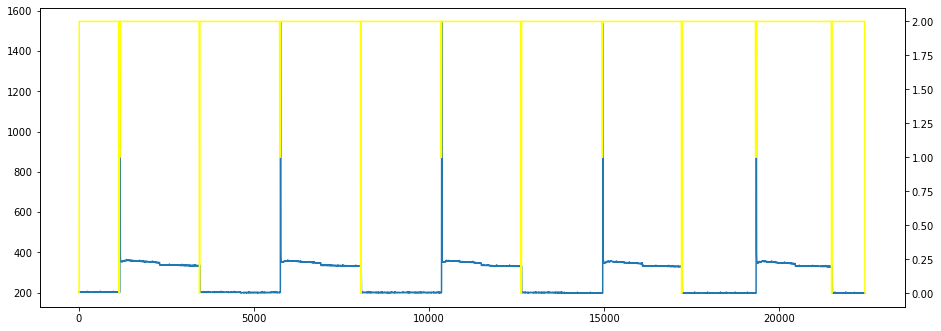

In [99]:
test_data['pred']=0
test_data['int_label']=0
test_data['pred'][:-15]=y_pred
test_data['int_label'][:-15]=y_true
start=00000
end=40000
fig,ax=plt.subplots()
ax2=ax.twinx()
fig.set_size_inches(15.5, 5.5)
test_data['mains_power'][start:end].plot(ax=ax)
test_data['pred'][start:end].plot(ax=ax2, color='yellow')
# training_data['int_label'][start:end].plot(ax=ax2, color='Red')

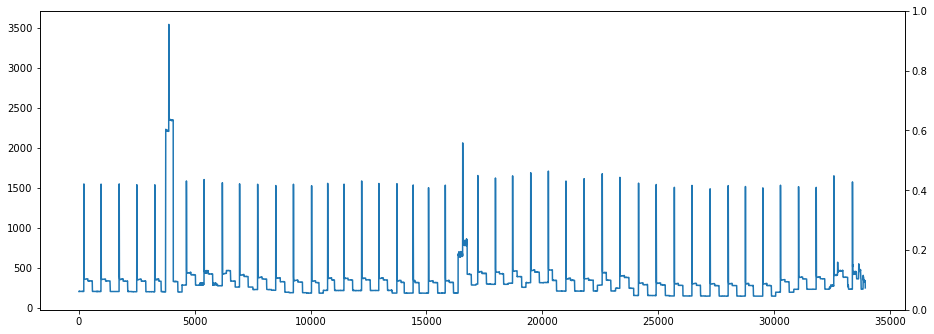

In [100]:
fig,ax=plt.subplots()
ax2=ax.twinx()
fig.set_size_inches(15.5, 5.5)
training_data['mains_power'].plot(ax=ax)

In [85]:
torch.save(InceptionTime.state_dict(), r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Raycon\Raycon Data\Inception_time.pth')

In [82]:
os.getcwd()

'C:\\Users\\Akshay Gupta\\Documents\\Projects\\Homescape\\Raycon\\Raycon Data'

In [22]:
pd.concat([sample_data.mains_power.shift(i) for i in range(10)], 1).fillna(0).values.tolist()

NameError: name 'sample_data' is not defined